___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# RNN Exercise

**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [4]:
df = pd.read_csv("data/Frozen_Dessert_Production.csv", parse_dates=True, index_col="DATE")

In [5]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**Task: Change the column name to Production**

In [6]:
df.columns = ["Production"]

In [7]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**TASK: Plot out the time series**

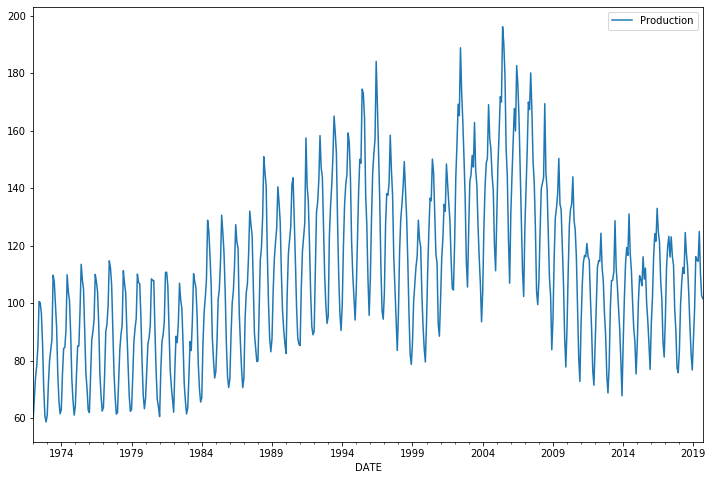

In [9]:
df.plot(figsize=(12,8));

## Train Test Split

**TASK: Figure out the length of the data set**

In [10]:
len(df)

573

**TASK: Split the data into a train/test split where the test set is the last 24 months of data.**

In [12]:
#CODE HERE

In [14]:
test_size = 24
test_ind = len(df) - test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [15]:
train.shape

(549, 1)

In [16]:
test.shape

(24, 1)

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality.**

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
length = 18
generator = TimeseriesGenerator(scaled_train, scaled_train,
                               length=length, batch_size=1)

In [24]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ],
         [0.01774221],
         [0.09850931],
         [0.15590133],
         [0.18358944],
         [0.20878908],
         [0.37150354]]]),
 array([[0.3542551]]))

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [22]:
n_features = 1

In [26]:
model = Sequential()

model.add(LSTM(100, activation="relu", input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer="adam",
             loss="mse")

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**TASK: Create a generator for the scaled test/validation set. NOTE: Double check that your batch length makes sense for the size of the test set as mentioned in the RNN Time Series video.**

In [28]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size=1)

In [29]:
validation_generator[0]

(array([[[0.23134679],
         [0.13655347],
         [0.12472921],
         [0.18015997],
         [0.29691617],
         [0.35382169],
         [0.39102302],
         [0.37592272],
         [0.47940099],
         [0.42586022],
         [0.3928192 ],
         [0.32470899],
         [0.2434103 ],
         [0.17289089],
         [0.13163033],
         [0.20608099],
         [0.28689318],
         [0.41822681]]]),
 array([[0.40948951]]))

**TASK: Create an EarlyStopping callback based on val_loss.**

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
early_stop = EarlyStopping(monitor="val_loss", patience=2)

**TASK: Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [32]:
model.fit_generator(generator,
                   epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
531/531 [==============================] - 14s 27ms/step - loss: 0.0273 - val_loss: 0.0044
Epoch 2/20
531/531 [==============================] - 15s 27ms/step - loss: 0.0121 - val_loss: 0.0035
Epoch 3/20
531/531 [==============================] - 15s 28ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 4/20
531/531 [==============================] - 15s 28ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 5/20
531/531 [==============================] - 15s 28ms/step - loss: 0.0037 - val_loss: 0.0026


**TASK: Plot the history of the loss that occured during training.**

In [33]:
losses = pd.DataFrame(model.history.history)

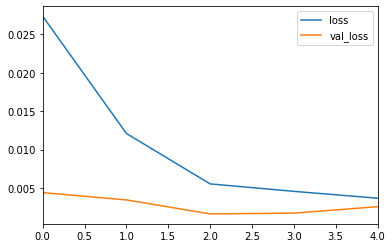

In [34]:
losses.plot()

## Evaluate on Test Data

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [36]:
true_preds = scaler.inverse_transform(test_predictions)

In [37]:
test["Predictions"] = true_preds

C:\Users\Luis\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
test.head()

,Production,Predictions
DATE,,
2017-10-01,90.4732,94.064727
2017-11-01,77.4378,88.988968
2017-12-01,75.8118,91.471156
2018-01-01,83.4343,100.145493
2018-02-01,99.4899,109.492171


**TASK: Plot your predictions versus the True test values. (Your plot may look different than ours).**

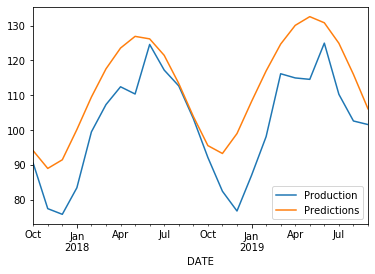

In [40]:
test.plot();

**TASK: Calculate your RMSE.**

In [41]:
from sklearn.metrics import mean_squared_error

In [45]:
mean_squared_error(test["Production"], test["Predictions"])**0.5

12.577993501361016

We should reduce the length to 12 as the trends are yearly.